# Generalisation and overfitting

In this notebook we will explore the issue of overfitting and how we can measure how well the models we train generalise their predictions to unseen data. This will build upon the introduction to generalisation given in the fourth lecture.

## Exercise 1: overfitting and model complexity in a 1D regression problem

As an exercise we will consider a regression problem. In particular, given a fixed set of (noisy) observations of the underlying functional relationship between inputs and outputs, we will attempt to use a multiple layer network model to learn to predict output values from inputs. The aim of the exercise will be to visualise how increasing the complexity of the model we fit to the training data effects the ability of the model to make predictions across the input space.

### Function

To keep things simple we will consider a single input-output function defined by a fourth degree polynomial (quartic)

$$ f(x) = 10 x^4 - 17 x^3 + 8 x^2 - x $$

with the observed values being the function values plus zero-mean Gaussian noise

$$ y = f(x) + 0.01 \epsilon \qquad \epsilon \sim \mathcal{N}\left(\cdot;\,0,\,1\right) $$

The inputs will be drawn from the uniform distribution on $[0, 1]$.

First import the necessary modules and seed the random number generator by running the cell below.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
seed = 17102016 
rng = np.random.RandomState(seed)

**Your Tasks:**

Write code in the cell below to calculate a polynomial function of one dimensional inputs. 

If $\boldsymbol{c}$ is a length $P$ vector of coefficients corresponding to increasing powers in the polynomial (starting from the constant zero power term up to the $P-1^{\textrm{th}}$ power) the function should correspond to the following

\begin{equation}
  f_{\textrm{polynomial}}(x,\ \boldsymbol{c}) = \sum_{p=0}^{P-1} \left( c_p x^p \right)
\end{equation}

In [2]:
def polynomial_function(inputs, coefficients):
    """Calculates polynomial with given coefficients of an array of inputs.
    
    Args:
        inputs: One-dimensional array of input values of shape (num_inputs,)
        coefficients: One-dimensional array of polynomial coefficient terms
           with `coefficients[0]` corresponding to the coefficient for the
           zero order term in the polynomial (constant) and `coefficients[-1]`
           corresponding to the highest order term.
           
    Returns:
        One dimensional array of output values of shape (num_inputs,)
    
    """
    outputs = []
    for x in inputs:
        result = sum(c * (x ** i) for i, c in enumerate(coefficients))
        outputs.append(result)
    return np.array(outputs)
    # raise NotImplementedError("TODO Implement this function") 

Run the cell below to test your implementation.

In [3]:
test_coefficients = np.array([-1., 3., 4.])
test_inputs = np.array([0., 0.5, 1., 2.])
test_outputs = np.array([-1., 1.5, 6., 21.])
assert polynomial_function(test_inputs, test_coefficients).shape == (4,), (
    'Function gives wrong shape output.'
)
assert np.allclose(polynomial_function(test_inputs, test_coefficients), test_outputs), (
    'Function gives incorrect output values.'
)
print("Function is correct!")

Function is correct!


We now need to use the random number generator to sample input values and calculate the corresponding target outputs using your polynomial implementation with the relevant coefficients for our function. Do this by running the cell below.

In [4]:
coefficients = np.array([0, -1., 8., -17., 10.])
input_dim, output_dim = 1, 1
noise_std = 0.01
num_data = 80
inputs = rng.uniform(size=(num_data, input_dim))
epsilons = rng.normal(size=num_data)
targets = (polynomial_function(inputs[:, 0], coefficients) + 
           epsilons * noise_std)[:, None]

We will split the generated data points in to equal sized training and validation data sets and use these to create data provider objects which we can use to train models in our framework. As the dataset is small here we will use a batch size equal to the size of the data set. Run the cell below to split the data and set up the data provider objects.

In [5]:
from mlp.data_providers import DataProvider
num_train = num_data // 2
batch_size = num_train
inputs_train, targets_train = inputs[:num_train], targets[:num_train]
inputs_valid, targets_valid = inputs[num_train:], targets[num_train:]
train_data = DataProvider(inputs_train, targets_train, batch_size=batch_size, rng=rng)
valid_data = DataProvider(inputs_valid, targets_valid, batch_size=batch_size, rng=rng)

We can now visualise the data we will be modelling. Run the cell below to plot the target outputs against inputs for both the training and validation sets. Note the clear underlying smooth functional relationship evident in the noisy data.

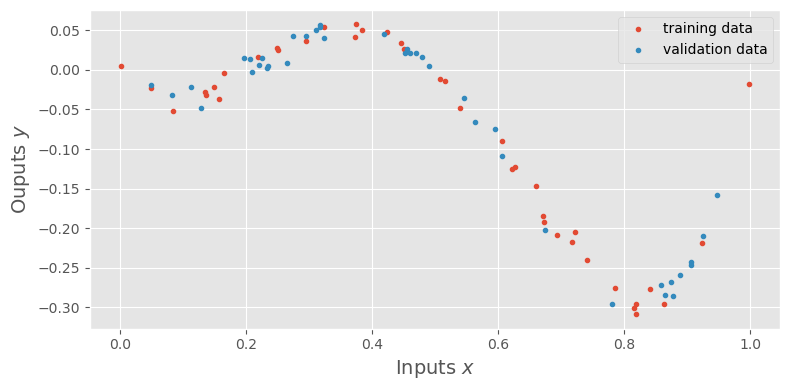

In [6]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.plot(inputs_train[:, 0], targets_train[:, 0], '.', label='training data')
ax.plot(inputs_valid[:, 0], targets_valid[:, 0], '.', label='validation data')
ax.set_xlabel('Inputs $x$', fontsize=14)
ax.set_ylabel('Ouputs $y$', fontsize=14)
ax.legend(loc='best')
fig.tight_layout()
plt.show()

### Model

We will fit models with a varying number of parameters to the training data. As multi-layer logistic sigmoid models tend to perform poorly in regressions tasks like this we will instead use a [radial basis function (RBF) network](https://en.wikipedia.org/wiki/Radial_basis_function_network).

This model predicts the output as the weighted sum of basis functions (here Gaussian like bumps) tiled across the input space. The cell below generates a random set of weights and bias for a RBF network and plots the modelled input-output function across inputs $[0, 1]$. Run the cell below for several different number of weight parameters (specified with `num_weights` variable) to get a feel for the sort of predictions the RBF network models produce.

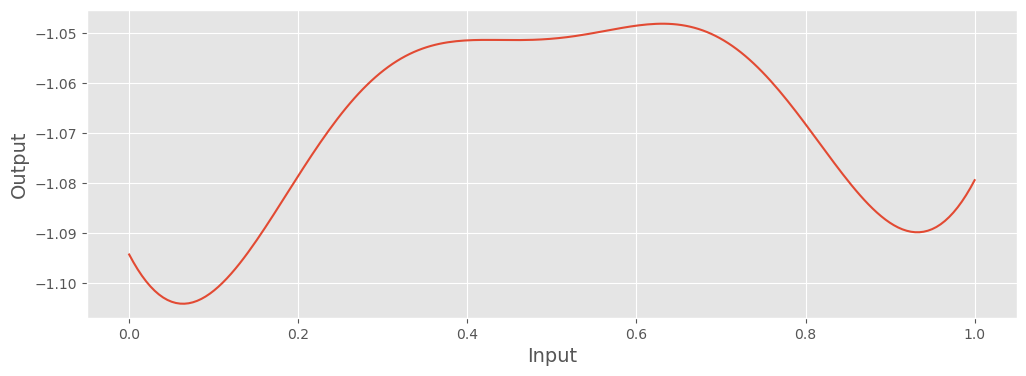

In [12]:
num_weights = 3
weights_scale = 1.
bias_scale = 1.

def basis_function(x, centre, scale):
    return np.exp(-(x - centre)**2 / scale**2)

weights = rng.normal(size=num_weights) * weights_scale
bias = rng.normal() * bias_scale

centres = np.linspace(0, 1, weights.shape[0])
scale = 1. / weights.shape[0]

xs = np.linspace(0, 1, 200)
ys = np.zeros(xs.shape[0])

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
for weight, centre in zip(weights, centres):
    ys += weight * basis_function(xs, centre, scale)
ys += bias
ax.plot(xs, ys)
ax.set_xlabel('Input', fontsize=14)
ax.set_ylabel('Output', fontsize=14)
plt.show()

You do not need to study the details of how to implement this model. All of the additional code you need to fit RBF networks is provided in the `RadialBasisFunctionLayer` in the `mlp.layers` module. The `RadialBasisFunctionLayer` class has the same interface as the layer classes we encountered in the previous lab, defining both `fprop` and `bprop` methods, and we can therefore include it as a layer in a `MultipleLayerModel` as with any other layer. 

Here we will use the `RadialBasisFunctionLayer` as the first layer in a two layer model. This first layer calculates the basis function terms which are then be weighted and summed together in an `AffineLayer`, the second and final layer. This illustrates the advantage of using a modular framework - we can reuse the code we previously implemented to train a quite different model architecture just by defining a new layer class. 

Run the cell below which contains some necessary setup code.

In [13]:
from mlp.models import MultipleLayerModel
from mlp.layers import AffineLayer, RadialBasisFunctionLayer
from mlp.errors import SumOfSquaredDiffsError
from mlp.initialisers import ConstantInit, UniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.optimisers import Optimiser

# Regression problem therefore use sum of squared differences error
error = SumOfSquaredDiffsError()
# Use basic gradient descent learning rule with fixed learning rate
learning_rule = GradientDescentLearningRule(0.1)
# Initialise weights from uniform distribution and zero bias
weights_init = UniformInit(-0.1, 0.1)
biases_init = ConstantInit(0.)
# Train all models for 2000 epochs
num_epoch = 2000

The next cell defines RBF network models with varying number of weight parameters (equal to the number of basis functions) and fits each to the training set, recording the final training and validation set errors for the fitted models. Run it now to fit the models and calculate the error values.

In [14]:
num_weight_list = [2, 5, 10, 25, 50, 100]
models = []
train_errors = []
valid_errors = []
for num_weight in num_weight_list:
    model = MultipleLayerModel([
        RadialBasisFunctionLayer(num_weight),
        AffineLayer(input_dim * num_weight, output_dim, 
                    weights_init, biases_init)
    ])
    optimiser = Optimiser(model, error, learning_rule, 
                            train_data, valid_data)
    print('-' * 80)
    print('Training model with {0} weights'.format(num_weight))
    print('-' * 80)
    _ = optimiser.train(num_epoch, -1)
    outputs_train = model.fprop(inputs_train)[-1]
    outputs_valid = model.fprop(inputs_valid)[-1]
    models.append(model)
    train_errors.append(error(outputs_train, targets_train))
    valid_errors.append(error(outputs_valid, targets_valid))
    print('  Final training set error: {0:.1e}'.format(train_errors[-1]))
    print('  Final validation set error: {0:.1e}'.format(valid_errors[-1]))

--------------------------------------------------------------------------------
Training model with 2 weights
--------------------------------------------------------------------------------
  Final training set error: 2.0e-03
  Final validation set error: 1.1e-03
--------------------------------------------------------------------------------
Training model with 5 weights
--------------------------------------------------------------------------------
  Final training set error: 4.5e-04
  Final validation set error: 3.0e-04
--------------------------------------------------------------------------------
Training model with 10 weights
--------------------------------------------------------------------------------
  Final training set error: 5.1e-05
  Final validation set error: 8.3e-05
--------------------------------------------------------------------------------
Training model with 25 weights
--------------------------------------------------------------------------------
  Final 

**Your Tasks**

In the cell below write code to [plot bar charts](http://matplotlib.org/examples/api/barchart_demo.html) of the training and validation set errors for the different fitted models.

Some questions to think about from the plots:

  * Do the models with more free parameters fit the training data better or worse?
  * What does the validation set error value tell us about the models?
  * Of the models fitted here which would you say seems like it is most likely to generalise well to unseen data? 
  * Do any of the models seem to be overfitting?

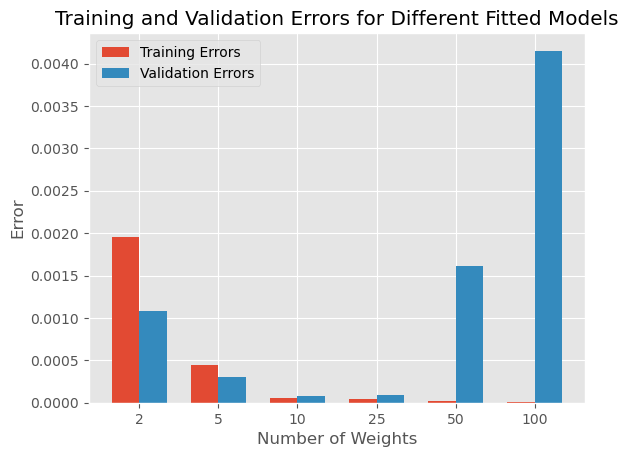

In [16]:
#TODO plot the bar charts here
train_errors = np.array(train_errors)
valid_errors = np.array(valid_errors)

bar_width = 0.35
x = np.arange(len(num_weight_list))

fig, ax = plt.subplots()
train_bars = ax.bar(x - bar_width / 2, train_errors, bar_width, label='Training Errors')
valid_bars = ax.bar(x + bar_width / 2, valid_errors, bar_width, label='Validation Errors')

ax.set_xlabel('Number of Weights')
ax.set_ylabel('Error')
ax.set_title('Training and Validation Errors for Different Fitted Models')
ax.set_xticks(x)
ax.set_xticklabels(num_weight_list)
ax.legend()

# Display the plot
plt.show()

Now let's visualise what the fitted model's predictions look like across the whole input space compared to the 'true' function we were trying to fit. 

**Your Tasks:**  

In the cell below, for each of the fitted models stored in the `models` list above:
  * Compute output predictions for the model across a linearly spaced series of 500 input points between 0 and 1 in the input space.
  * Plot the computed predicted outputs and true function values at the corresponding inputs as line plots on the same axis (use a new axis for each model).
  * On the same axis plot the training data sets input-target pairs as points.

In [19]:
#TODO plot the graphs here
test_input = np.linspace(0,1,500)
for model in models:
    output_test = model.fpro(test_input)[-1]


for num_weight in num_weight_list:
    model = MultipleLayerModel([
        RadialBasisFunctionLayer(num_weight),
        AffineLayer(input_dim * num_weight, output_dim, 
                    weights_init, biases_init)
    ])
    optimiser = Optimiser(model, error, learning_rule, 
                            train_data, valid_data)
    print('-' * 80)
    print('Training model with {0} weights'.format(num_weight))
    print('-' * 80)
    _ = optimiser.train(num_epoch, -1)
    outputs_test = model.fprop(test_input)[-1]
    models.append(model)
    train_errors.append(error(outputs_train, targets_train))
    valid_errors.append(error(outputs_valid, targets_valid))
    print('  Final training set error: {0:.1e}'.format(train_errors[-1]))
    print('  Final validation set error: {0:.1e}'.format(valid_errors[-1]))

500


You should be able to relate your answers to the questions above to what you see in these plots - ask a demonstrator if you are unsure what is going on. In particular for the models which appeared to be overfitting and generalising poorly you should now have an idea how this looks in terms of the model's predictions and how these relate to the training data points and true function values.


# PyTorch

As we have seen in the [previous lab](https://github.com/VICO-UoE/mlpractical/tree/mlp2023-24/lab3/notebooks/03_Multiple_layer_models.ipynb), our model shows signs of overfitting after $15$ epochs. 

Overfitting occurs when the model learns the training data too well, and fails to generalise to unseen data. In this case, the model learns the noise in the training data, and fails to learn the underlying function. 

The model may be too complex, and we can reduce the complexity by reducing the number of parameters. However, this may not be the best solution, as we may not be able to learn the underlying function with a simple model.

In practice, a model that overfits the training data will have a low training error, but a high validation error.

*What can we deduce if we observe a high training error and a high validation error?*

Overfitting is a common problem in machine learning, and there are many techniques to avoid it. In this lab, we will explore one of them: *early stopping*.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler

torch.manual_seed(seed)

In [35]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set training run hyperparameters
batch_size = 128  # number of data points in a batch
learning_rate = 0.001  # learning rate for gradient descent
num_epochs = 50  # number of training epochs to perform
stats_interval = 1  # epoch interval between recording and printing stats

In [ ]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transform)

valid_size=0.2 # Leave 20% of training set as validation set
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices) # Shuffle indices in-place
train_idx, valid_idx = indices[split:], indices[:split] # Split indices into training and validation sets
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create the dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [37]:
class MultipleLayerModel(nn.Module):
    """Multiple layer model."""
    def __init__(self, input_dim, output_dim, hidden_dim):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
input_dim = 1*28*28
output_dim = 10
hidden_dim = 100

model = MultipleLayerModel(input_dim, output_dim, hidden_dim).to(device)

loss = nn.CrossEntropyLoss() # Cross-entropy loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimiser

Early stopping is a simple technique to avoid overfitting. The idea is to stop training when the validation error starts to increase. This is usually done by monitoring the validation error during training, and stopping when it has not decreased for a certain number of epochs.

*Can we state that overfitting is ultimatelly inevitable given training over a very large number of epochs?*

In this section, we will implement early stopping in PyTorch. We will use the same model as in the previous lab, but we will train it for $50$ epochs with an early stopping.

In [38]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, min_delta=0):

        self.patience = patience # Number of epochs with no improvement after which training will be stopped
        self.min_delta = min_delta # Minimum change in the monitored quantity to qualify as an improvement
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.early_stop = False

    def __call__(self, validation_loss):
        # If validation loss is lower than minimum validation loss so far,
        # reset counter and set minimum validation loss to current validation loss
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        # If validation loss hasn't improved since minimum validation loss,
        # increment counter
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            # If counter has reached patience, set early_stop flag to True
            if self.counter >= self.patience: 
                self.early_stop = True

In [ ]:
# Initialise early stopping object
early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Keep track of the loss values over training
train_loss = [] 
valid_loss = []

# Train model
for i in range(num_epochs+1):
    # Training
    model.train()
    batch_loss = []
    for batch_idx, (x, t) in enumerate(train_loader):
        x = x.to(device)
        t = t.to(device)
        
        # Forward pass
        y = model(x)
        E_value = loss(y, t)
        
        # Backward pass
        optimizer.zero_grad()
        E_value.backward()
        optimizer.step()
        
        # Logging
        batch_loss.append(E_value.item())
    
    train_loss.append(np.mean(batch_loss))

    # Validation
    model.eval()
    batch_loss = []
    for batch_idx, (x, t) in enumerate(valid_loader):
        x = x.to(device)
        t = t.to(device)
        
        # Forward pass
        y = model(x)
        E_value = loss(y, t)
        
        # Logging
        batch_loss.append(E_value.item())
    
    valid_loss.append(np.mean(batch_loss))

    if i % stats_interval == 0:
            print('Epoch: {} \tError(train): {:.6f} \tError(valid): {:.6f} '.format(
                i, train_loss[-1], valid_loss[-1]))
            
    # Check for early stopping
    early_stopping(valid_loss[-1])

    if early_stopping.early_stop:
        print("Early stopping")
        break # Stop training

In [ ]:
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
ax_1.plot(train_loss, label='Error(train)')
ax_1.plot(valid_loss, label='Error(valid)')
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')
plt.show()